In [140]:
from PINNs import Bound, PhysicsBound, PINN, NVS, NetworkTrainer, Visualization
import torch
import matplotlib.pyplot as plt

## 1. Define Physical Space

Define physical bound

In [141]:
# Define the channel geometry boundaries

# Automatically define bound
bound_list = Bound.create_rectangle_bound([0,1.1],[0,0.41]) + Bound.create_circle_bound(0.2,0.2,0.05,False)


Plot Physical bound

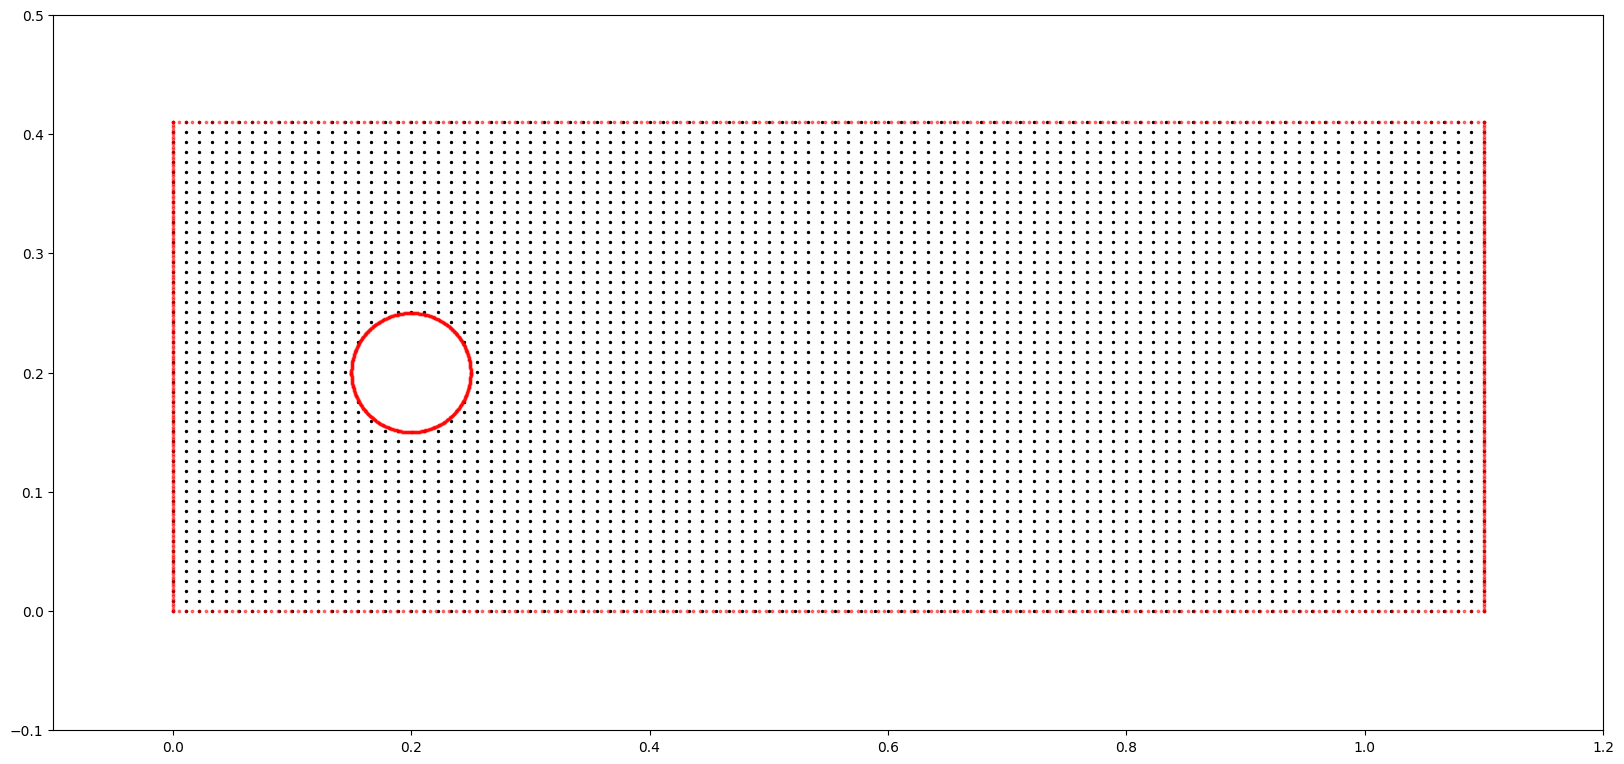

In [142]:
X, Y = Bound.sampling_area(bound_list, [100,50], [0,1.1], [0,0.41])

sampling_resolution_list = [200, 200, 200, 200, 200, 200]

plt.figure(figsize=(20,20))
plt.scatter(X,Y,s=2, color='black')
for i,bound in enumerate(bound_list):
    x,y = bound.sampling_line(sampling_resolution_list[i])
    plt.scatter(x,y,s=3, color='red', alpha=0.5)
plt.xlim(-0.1,1.2)
plt.ylim(-0.1,0.5)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


### Define Boundary Conditions and PDE Area

In [143]:
# Define the physics at the boundaries
physics_cond_list = [
    {'u': 0.0, 'v': 0.0},      # Top wall: No-slip
    {'u': 0.0, 'v': 0.0},      # Bottom wall: No-slip
    {'u': ['y', lambda y:  4*0.1*(0.41-y)*y/0.41**2], 'v': 0.0},      # Inlet: Parabolic inflow
    {'p': 0.0},                # Outlet: Zero pressure
    {'u': 0.0, 'v': 0.0},
    {'u': 0.0, 'v': 0.0},
]

# Create a list of boundary condition objects and define the PDE area
boundary_conditions_list = [
    PhysicsBound.define_boundary_condition(bound, cond) 
    for bound, cond in zip(bound_list, physics_cond_list)
]
# Define PDE area
area_physics_bound = PhysicsBound.define_pde_area(
    bound_list=bound_list, 
    sampling_range_x=[0, 1.1], 
    sampling_range_y=[0, 0.41], 
    PDE_class=NVS()
)

### Sampling points

In [144]:
# Define sampling resolutions and sampling function
sampling_resolution_list = [200, 200, 200, 200, 200, 200]
area_sampling_resolution = 486

# def uniform_sampling():
#     for i,bc in enumerate(boundary_conditions_list):
#         bc.sampling_collocation_points(sampling_resolution_list[i])
#     area_physics_bound.sampling_collocation_points([44,220])

n = 0
sampling_frequency = 300
def random_sampling(bound_sampling_resolution_list, area_sampling_resolution):
    global n, sampling_frequency
    if n%sampling_frequency==0 or n==0:
        print('sampling')
        for i, bc in enumerate(boundary_conditions_list):
            bc.sampling_collocation_points(bound_sampling_resolution_list[i], random=True)
        area_physics_bound.sampling_collocation_points(area_sampling_resolution, random=True)
    n += 1
area_sampling_resolution = 486

## Define the Model and Loss Function

In [145]:
model0 = PINN(width=32, length=8)

In [146]:
# Define the loss calculation function
loss_fn = torch.nn.MSELoss()
def calc_loss(model):
    # Re-sample the collocation points at each step
    random_sampling(sampling_resolution_list,486)

    # BC Loss
    bc_loss = 0
    for i, bc in enumerate(boundary_conditions_list):
        bc_loss += bc.calc_loss(model, loss_fn)

    # PDE Loss
    pde_loss = area_physics_bound.calc_loss(model)
    
    # Total Loss
    total_loss = bc_loss + pde_loss
    return {"bc_loss": bc_loss, "pde_loss": pde_loss, "total_loss": total_loss}

In [147]:
# Train the model
model1 = NetworkTrainer.train_adam(
    model=model0,
    calc_loss=calc_loss,
    learning_rate=0.001,
    epochs=4000,
    print_every=100
)

sampling
epoch 1, total_loss: 0.08483, bc_loss: 0.08482, pde_loss: 0.00001
epoch 101, total_loss: 0.00195, bc_loss: 0.00193, pde_loss: 0.00002
epoch 201, total_loss: 0.00179, bc_loss: 0.00175, pde_loss: 0.00004
sampling
epoch 301, total_loss: 0.00151, bc_loss: 0.00147, pde_loss: 0.00004
epoch 401, total_loss: 0.00140, bc_loss: 0.00136, pde_loss: 0.00004
epoch 501, total_loss: 0.00135, bc_loss: 0.00132, pde_loss: 0.00003
sampling
epoch 601, total_loss: 0.00136, bc_loss: 0.00131, pde_loss: 0.00005
epoch 701, total_loss: 0.00128, bc_loss: 0.00121, pde_loss: 0.00006
epoch 801, total_loss: 0.00122, bc_loss: 0.00120, pde_loss: 0.00002
sampling
epoch 901, total_loss: 0.00132, bc_loss: 0.00129, pde_loss: 0.00003
epoch 1001, total_loss: 0.00111, bc_loss: 0.00106, pde_loss: 0.00005
epoch 1101, total_loss: 0.00093, bc_loss: 0.00089, pde_loss: 0.00004
sampling
epoch 1201, total_loss: 0.00085, bc_loss: 0.00073, pde_loss: 0.00012
epoch 1301, total_loss: 0.00076, bc_loss: 0.00066, pde_loss: 0.00011
e

Continue training with higher sampling rate

In [148]:
sampling_resolution_list = [200, 200, 200, 200, 200, 200]
area_sampling_resolution = 4860

In [149]:
# For better results, continue training with a smaller learning rate
model2 = NetworkTrainer.train_adam(
    model=model1, 
    calc_loss=calc_loss, 
    learning_rate=0.001, 
    epochs=1000, 
    print_every=100
)

epoch 4001, total_loss: 0.00030, bc_loss: 0.00017, pde_loss: 0.00012
epoch 4101, total_loss: 0.00040, bc_loss: 0.00032, pde_loss: 0.00008
sampling
epoch 4201, total_loss: 0.00038, bc_loss: 0.00027, pde_loss: 0.00010
epoch 4301, total_loss: 0.00032, bc_loss: 0.00020, pde_loss: 0.00012
epoch 4401, total_loss: 0.00031, bc_loss: 0.00018, pde_loss: 0.00013
sampling
epoch 4501, total_loss: 0.00032, bc_loss: 0.00016, pde_loss: 0.00016
epoch 4601, total_loss: 0.00030, bc_loss: 0.00017, pde_loss: 0.00013
epoch 4701, total_loss: 0.00029, bc_loss: 0.00016, pde_loss: 0.00013
sampling
epoch 4801, total_loss: 0.00029, bc_loss: 0.00015, pde_loss: 0.00014
epoch 4901, total_loss: 0.00026, bc_loss: 0.00014, pde_loss: 0.00012


## 3. Visualize the Results

In [150]:
# Create visualization object
visual_model = Visualization(area_physics_bound, model2)
visual_model.sampling_plot_points(800,80)
keyword = visual_model.process_model()
print(keyword) #printing keyword using for plotclor_select()

2.682926829268293
(['u', 'v', 'p', 'u_x', 'v_x', 'p_x', 'u_y', 'v_y', 'p_y', 'u_xx', 'v_xx', 'u_yy', 'v_yy', 'residual', 'velocity_magnitude'], ['total_loss', 'bc_loss', 'pde_loss'])


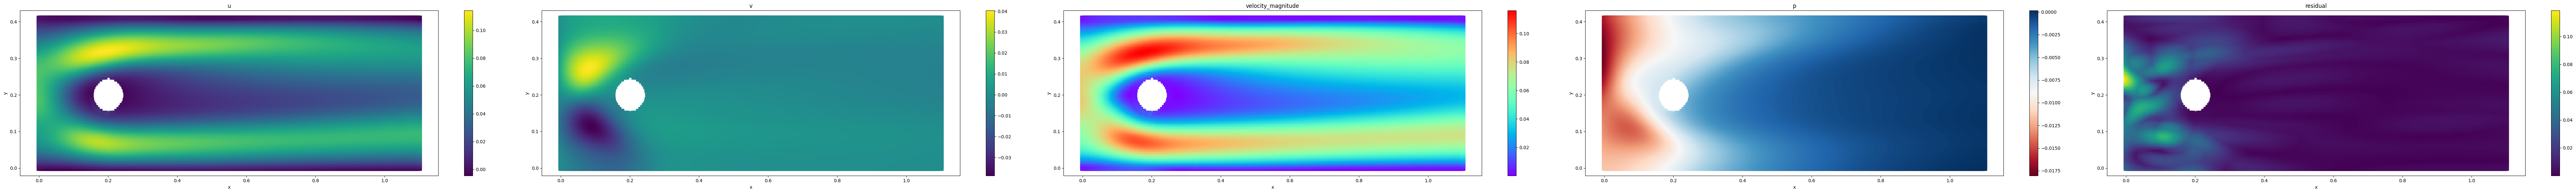

In [151]:
cmap_dict = {
    'u':None,
    'v':None,
    'velocity_magnitude': 'rainbow',
    'p':'RdBu',
    'residual':None
}
colorplot_all = visual_model.plotcolor_select(cmap_dict)
colorplot_all.savefig('cylinder_flow_steady_all.png')

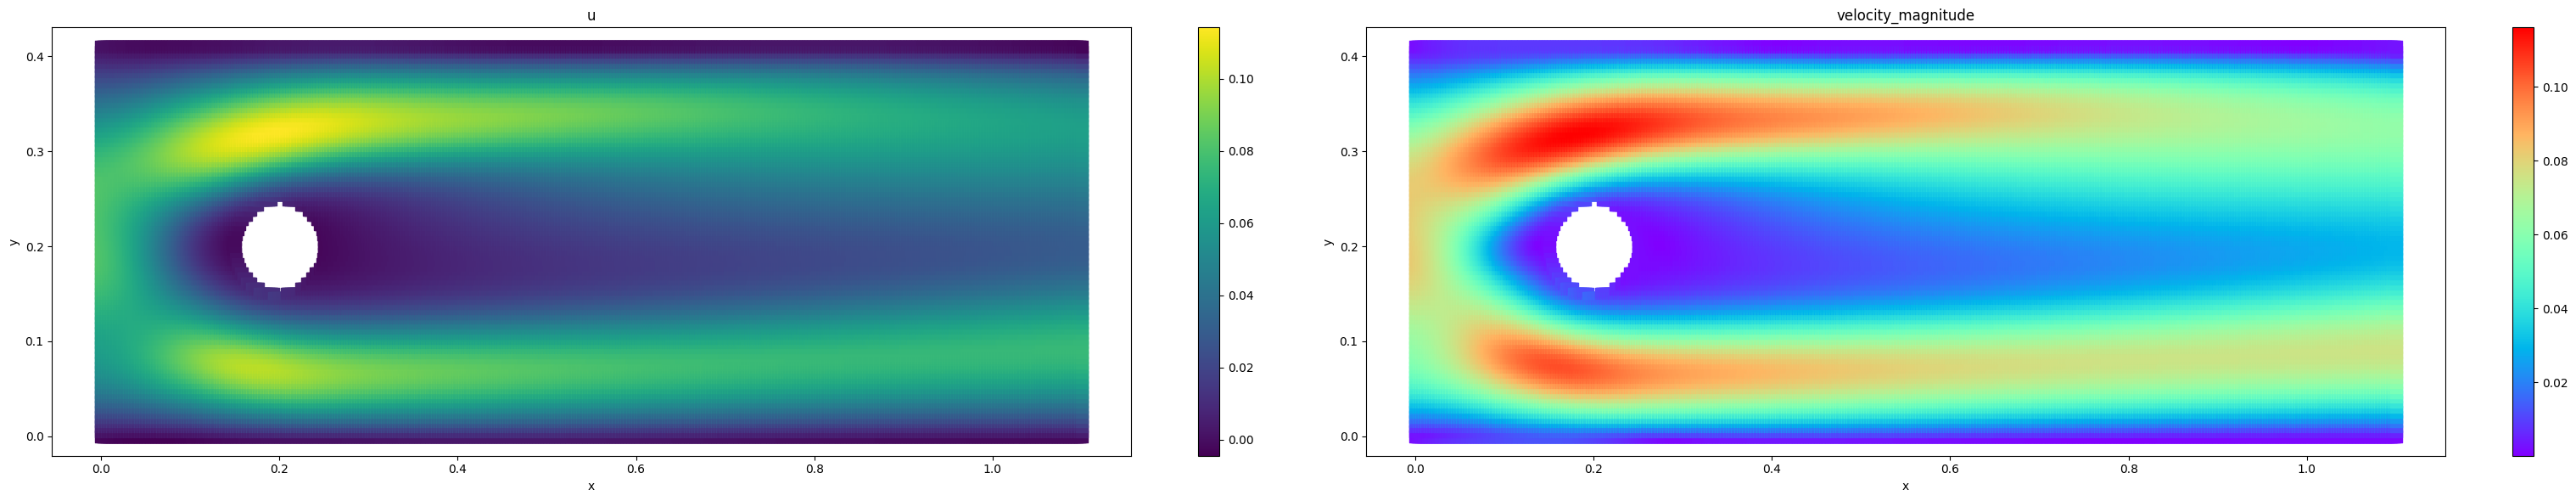

In [152]:
cmap_dict = {'u':None, 'velocity_magnitude': 'rainbow'}
colorplot = visual_model.plotcolor_select(cmap_dict)
colorplot.savefig('cylinder_flow_steady.png')

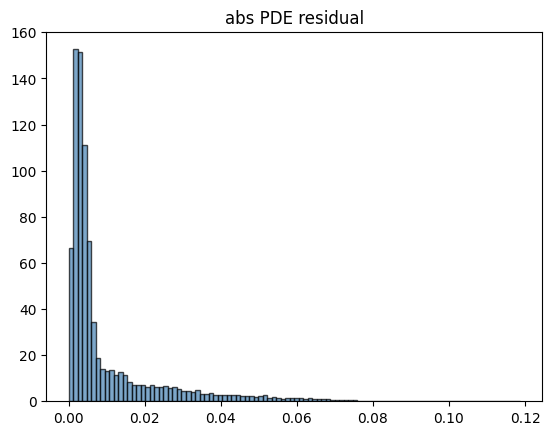

In [153]:
residual_plot = visual_model.plot_residual_distribution()
residual_plot.savefig('residual.png')

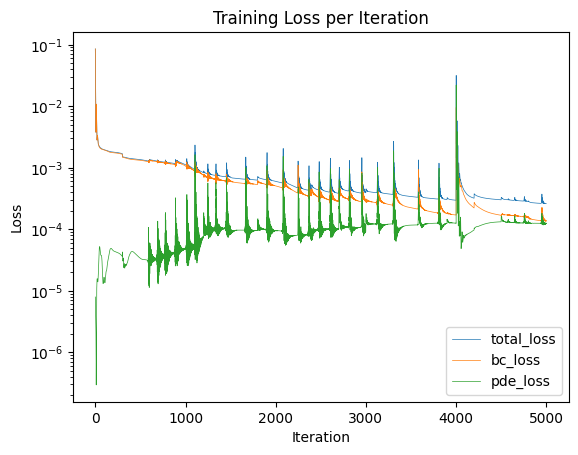

In [154]:
residual_plot = visual_model.plot_loss_evolution(log_scale=True, linewidth=0.5)
residual_plot.savefig('loss_evolution.png')

## Visualization without tools

In [155]:
import numpy as np
import PINNs
area_physics_bound.sampling_collocation_points([400,40])
area_physics_bound.process_model(model1)
area_physics_bound.process_pde()
X,Y,T = area_physics_bound.model_inputs.values()
U,V,P = area_physics_bound.model_outputs.values()
residual = area_physics_bound.PDE.calc_residual_sum()
X,Y,U,V,P,residual = PINNs.torch_to_numpy(X,Y,U,V,P,residual)
V_size = np.sqrt(U**2+V**2)


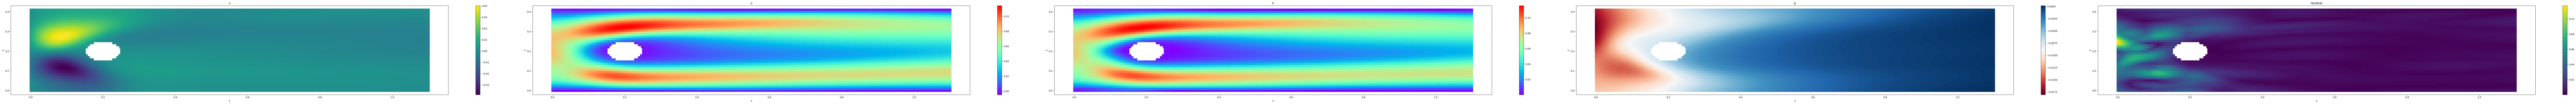

In [156]:
from PINNs import Visualization
fig, axes = plt.subplots(1,5, figsize=(6*5*5,6))
s =80
Visualization.colorplot(X.flatten(),Y.flatten(),V.flatten(),axes[0],'v','viridis',s)
Visualization.colorplot(X.flatten(),Y.flatten(),U.flatten(),axes[1],'u','rainbow',s)
Visualization.colorplot(X.flatten(),Y.flatten(),V_size.flatten(),axes[2],'V','rainbow',s)
Visualization.colorplot(X.flatten(),Y.flatten(),P.flatten(),axes[3],'p','RdBu',s)
Visualization.colorplot(X.flatten(),Y.flatten(),residual.flatten(),axes[4],'residual','viridis',s)
plt.tight_layout()
plt.show()

In [157]:
outlet_bound = boundary_conditions_list[2]
outlet_bound.sampling_collocation_points(1000)
outlet_bound.pde_define(NVS())
outlet_bound.process_model(model1)
outlet_bound.process_pde()
X,Y,T = outlet_bound.model_inputs.values()
U,V,P = outlet_bound.model_outputs.values()
X,Y,U,P,V = PINNs.torch_to_numpy(X,Y,U,V,P)

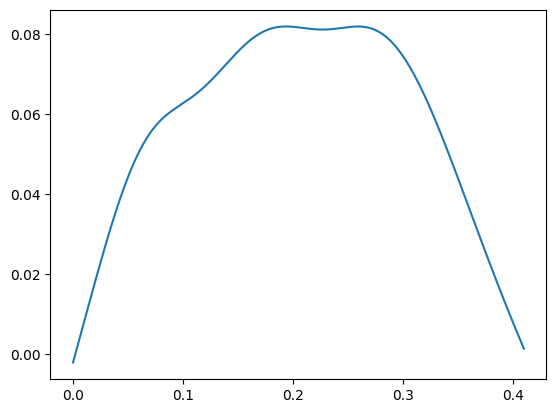

In [158]:
plt.plot(Y.flatten(), U.flatten())
plt.show()